# Forecasting temperature with SARIMA
## Abstract
The aim for this project is to find an appropriate model able to forecast monthly mean air temperature in Stockholm. 

# Introduction

> Temperature forecasting is a challenging but important task. The areas in need of accurate forecasting are many, ranging from agriculture to energy consumption. An increase in air temperature would also lead to sea-level rise, global warming and will negatively impact humans. 

> In this notebook, air temperature in Stockholm was modeled by Seasonal Autoregressive Moving Average (SARIMA).


https://irjabs.com/files_site/paperlist/r_449_121110152548.pdf

http://www.statistics.du.se/essays/D09_Xier_Li.pdf

http://www.statistics.du.se/essays/D08D_XiangJunquan.pdf

In [58]:
library(ggplot2);
library(plotly);
library(ggfortify);
library(repr);
library(tidyr);
library(tsibble);
library(TSstudio);
library(zoo);
library(dplyr);
library(forecast);

library(ggridges)
library(viridis)
library(hrbrthemes)

Sys.setlocale(locale = "English");
windowsFonts(Times=windowsFont("Times New Roman"));

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  autoplot.acf           ggfortify
  autoplot.ar            ggfortify
  autoplot.bats          ggfortify
  autoplot.decomposed.ts ggfortify
  autoplot.ets           ggfortify
  autoplot.forecast      ggfortify
  autoplot.stl           ggfortify
  autoplot.ts            ggfortify
  fitted.ar              ggfortify
  fortify.ts             ggfortify
  residuals.ar           ggfortify



[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

https://bolin.su.se/data/stockholm-historical-monthly-temperature-3?n=stockholm-historical-temps-monthly-3

# Data source
The data consist out of 36 years of monthly mean air temperatures. 

In [2]:
dataset = read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
#rownames(dt) = as.integer(as.character(dt$year))
min_year = min(dataset$year)
max_year = max(dataset$year)
#dt = dt[,-1]
head(dataset)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [3]:
train = ts(as.vector(t(as.matrix(dataset[,-1]))), start=c(1980, 1), end=c(max_year, 12), frequency =12)

In [4]:
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))

train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

head(train_reshape)

,date,temp,month,year
,<date>,<dbl>,<chr>,<chr>
1,1980-01-01,-4.7,Jan,1980
2,1980-02-01,-6.2,Feb,1980
3,1980-03-01,-3.1,Mar,1980
4,1980-04-01,4.8,Apr,1980
5,1980-05-01,7.8,May,1980
6,1980-06-01,15.6,Jun,1980


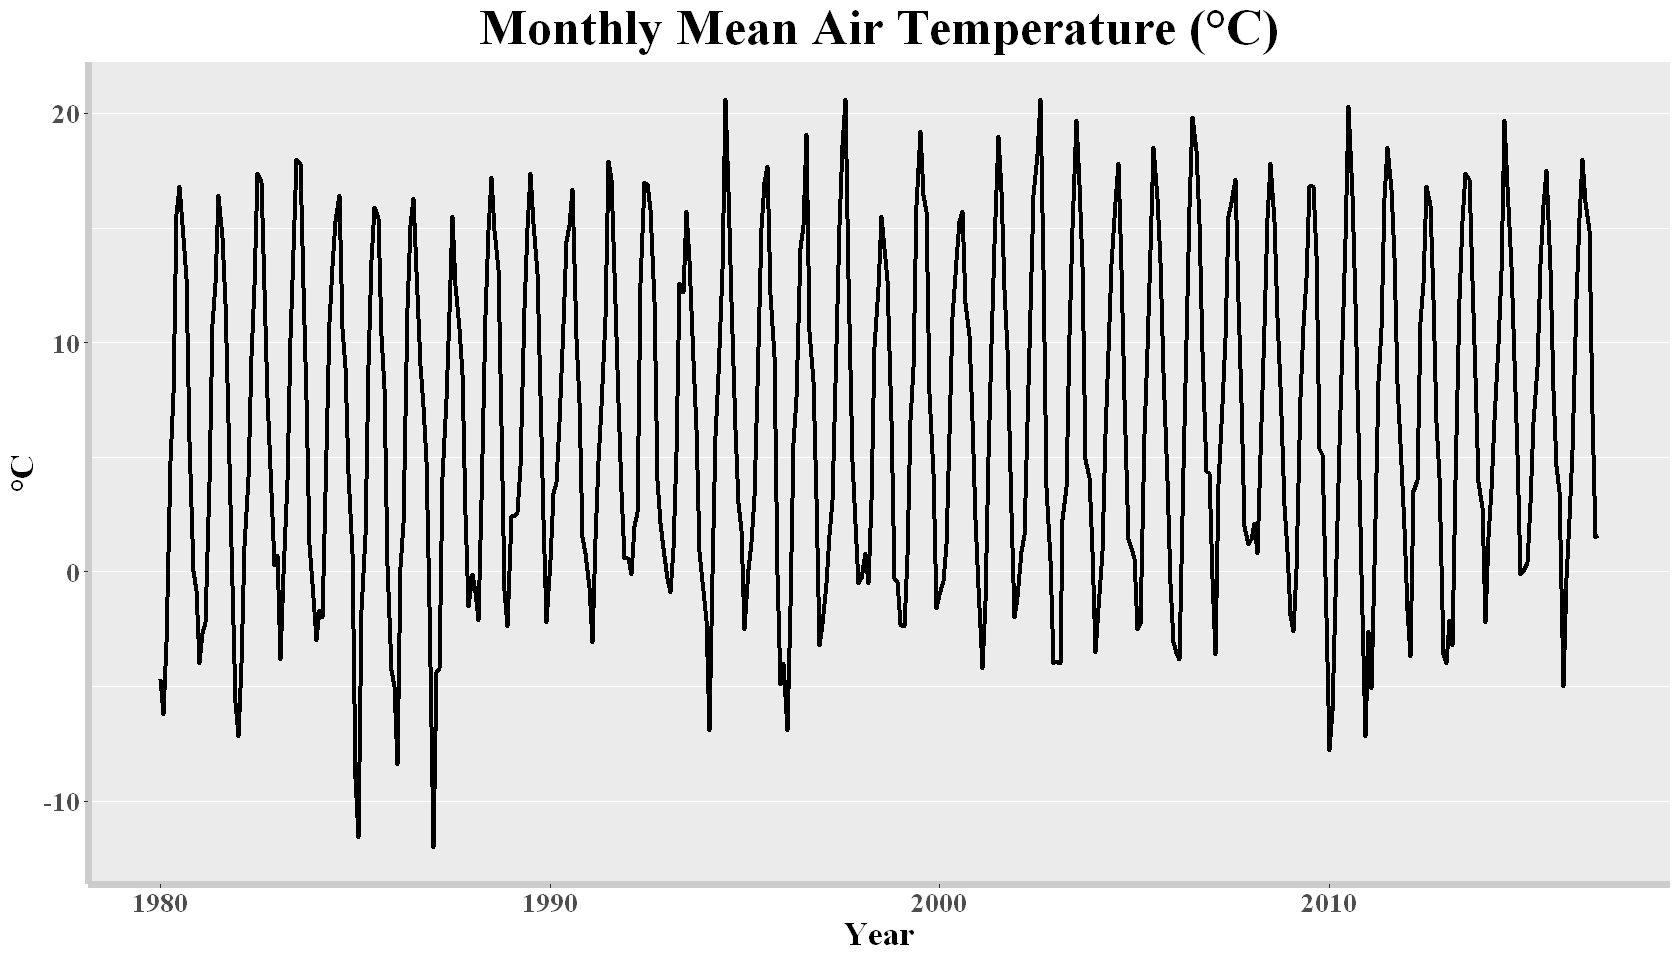

In [16]:
options(repr.plot.width=14, repr.plot.height=8)
autoplot(train, xlab="Year", ylab="°C", size = 1.2)+
    ggtitle("Monthly Mean Air Temperature (°C)")+
    guides(colour = guide_legend(title.hjust = 20))+
    theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 30, face = "bold",  family="Times", hjust = 0.5),
        axis.line = element_line(size = 2, colour = "grey80"),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank())

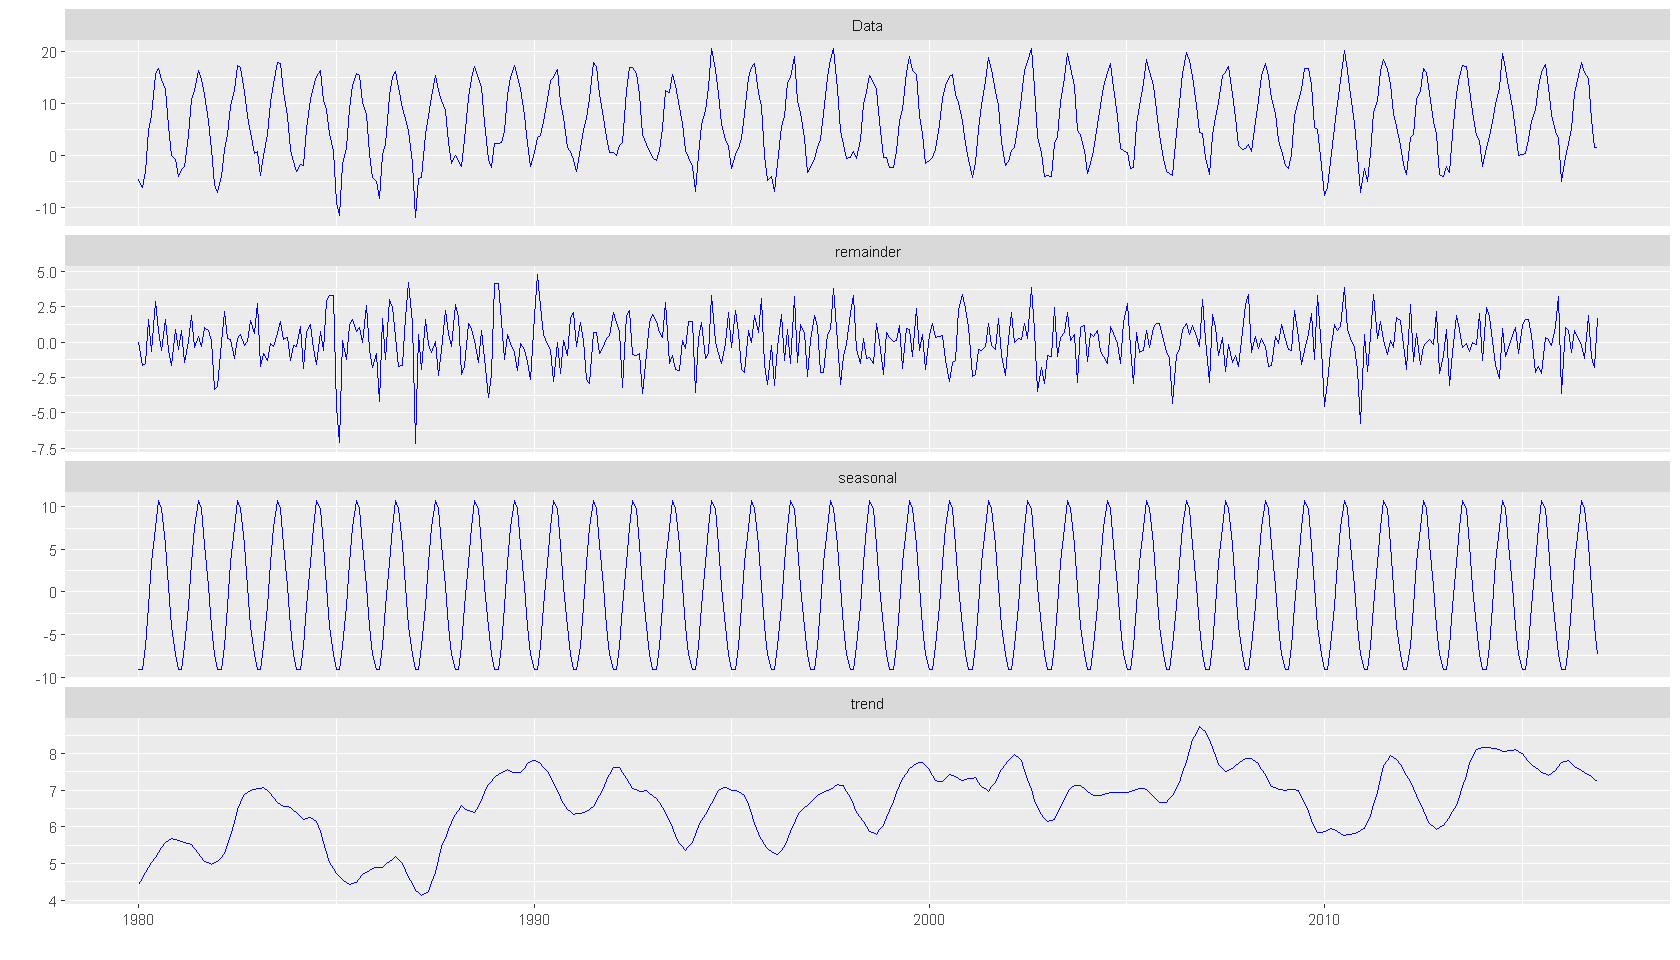

In [15]:
autoplot(stl(train, s.window = 'periodic'), ts.colour = 'blue')

> Ridgeline plot. Potential outliers in January and February. 

Picking joint bandwidth of 0.787



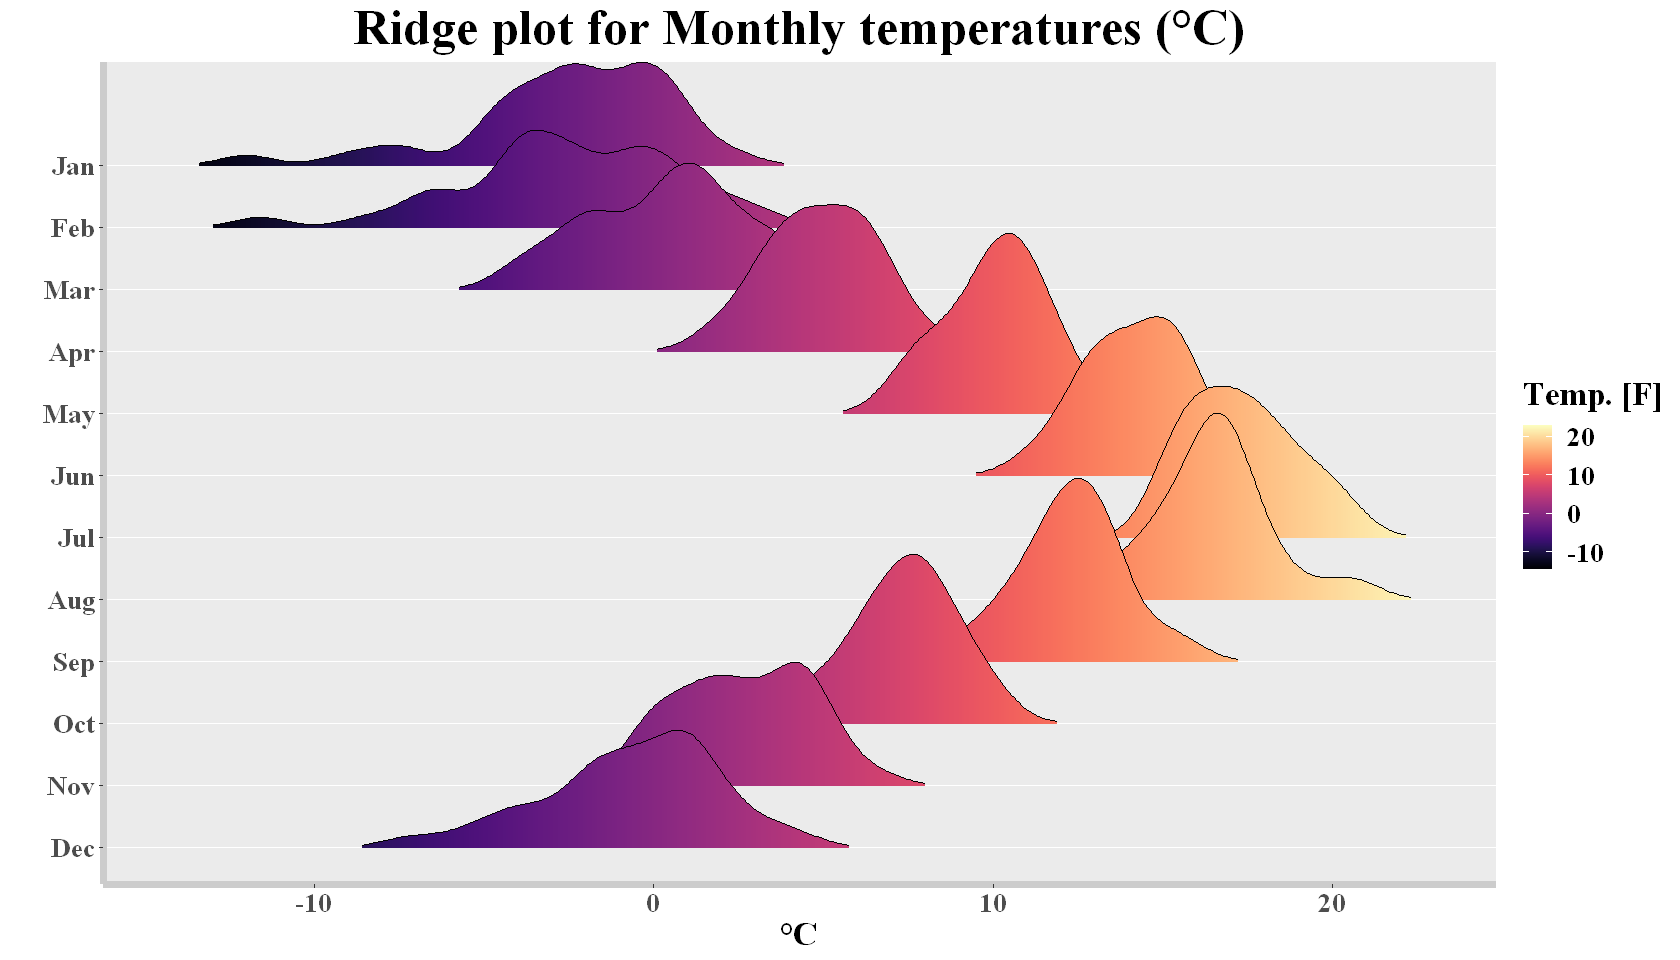

In [59]:
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..)) +
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("°C") + ylab("") +
    theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 30, face = "bold",  family="Times", hjust = 0.5),
        axis.line = element_line(size = 2, colour = "grey80"),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank())

Outliers are better visualised through a boxplot.

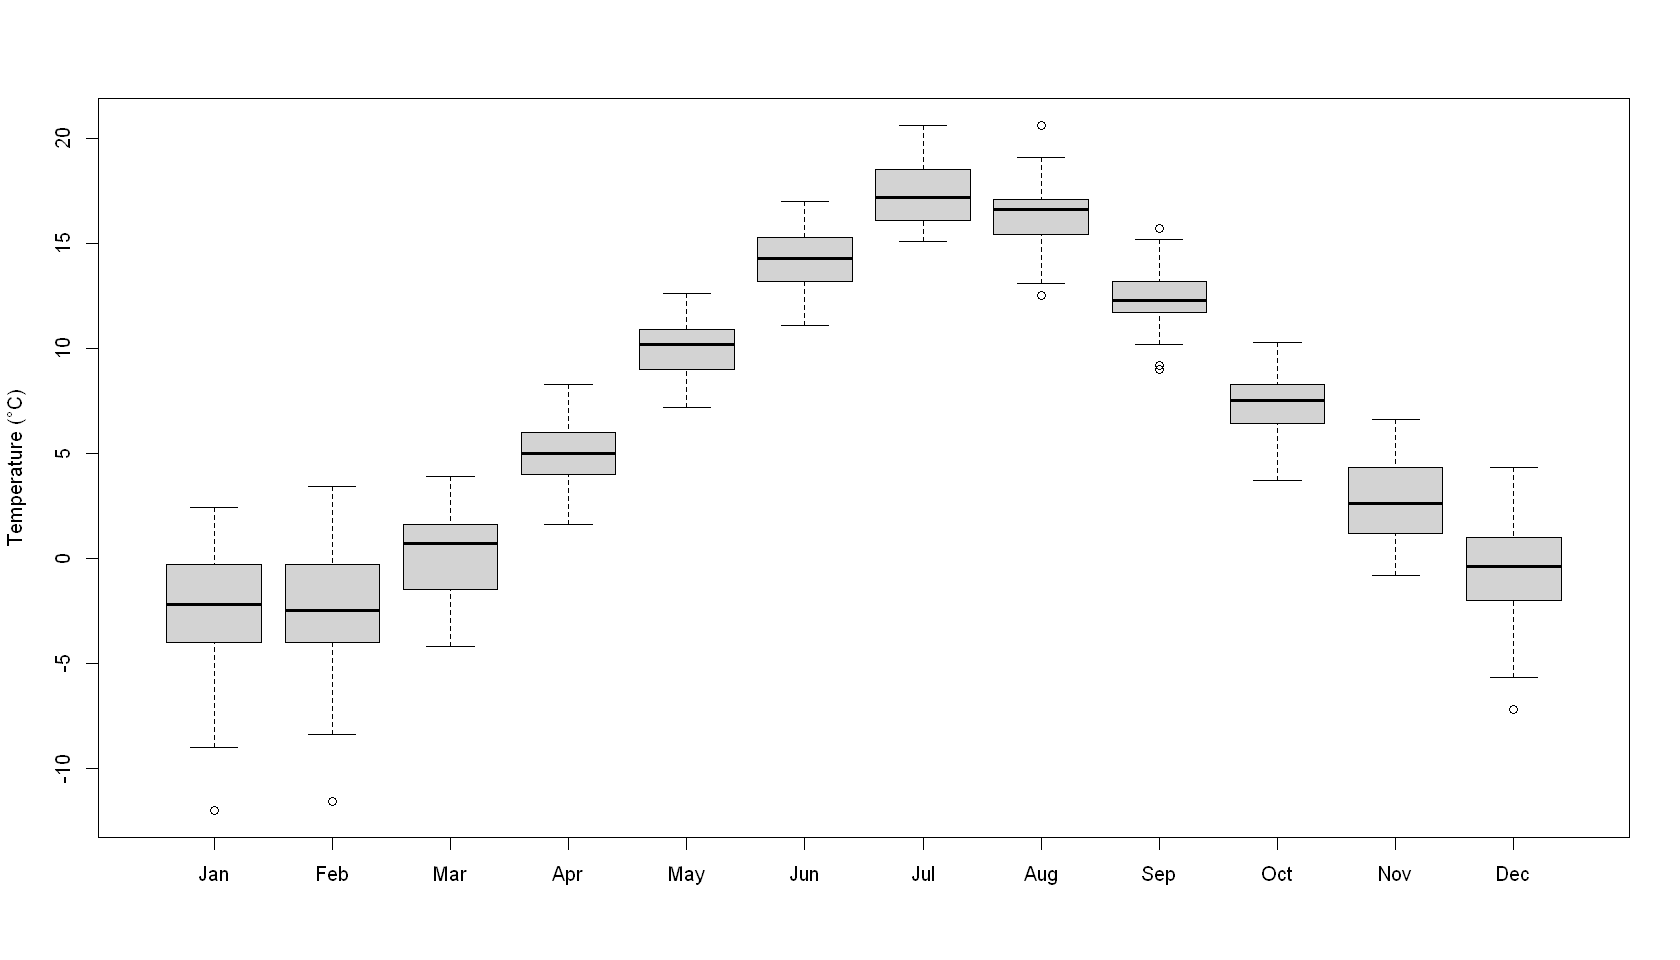

In [18]:
boxplot(train~cycle(train), names=month.abb, xlab="", ylab="Temperature (°C)")

In [7]:
#fig <- plot_ly(train_reshape , x = ~date, y = ~temp, type = 'scatter', mode = 'lines') %>%
#        layout(title = 'Monthly Mean Air Temperature (°C)', plot_bgcolor = "#e5ecf6")
#fig

In [10]:
heatmap(train_reshape[,c(4,3,2)])

ERROR: Error in heatmap(train_reshape[, c(4, 3, 2)]): 'x' must be a numeric matrix


For example, a root near 1 of the autoregressive polynomial suggests that the data
should be differenced before fitting an ARMA model, whereas a root near 1 of
the moving-average polynomial indicates that the data were overdifferenced.

In [19]:
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



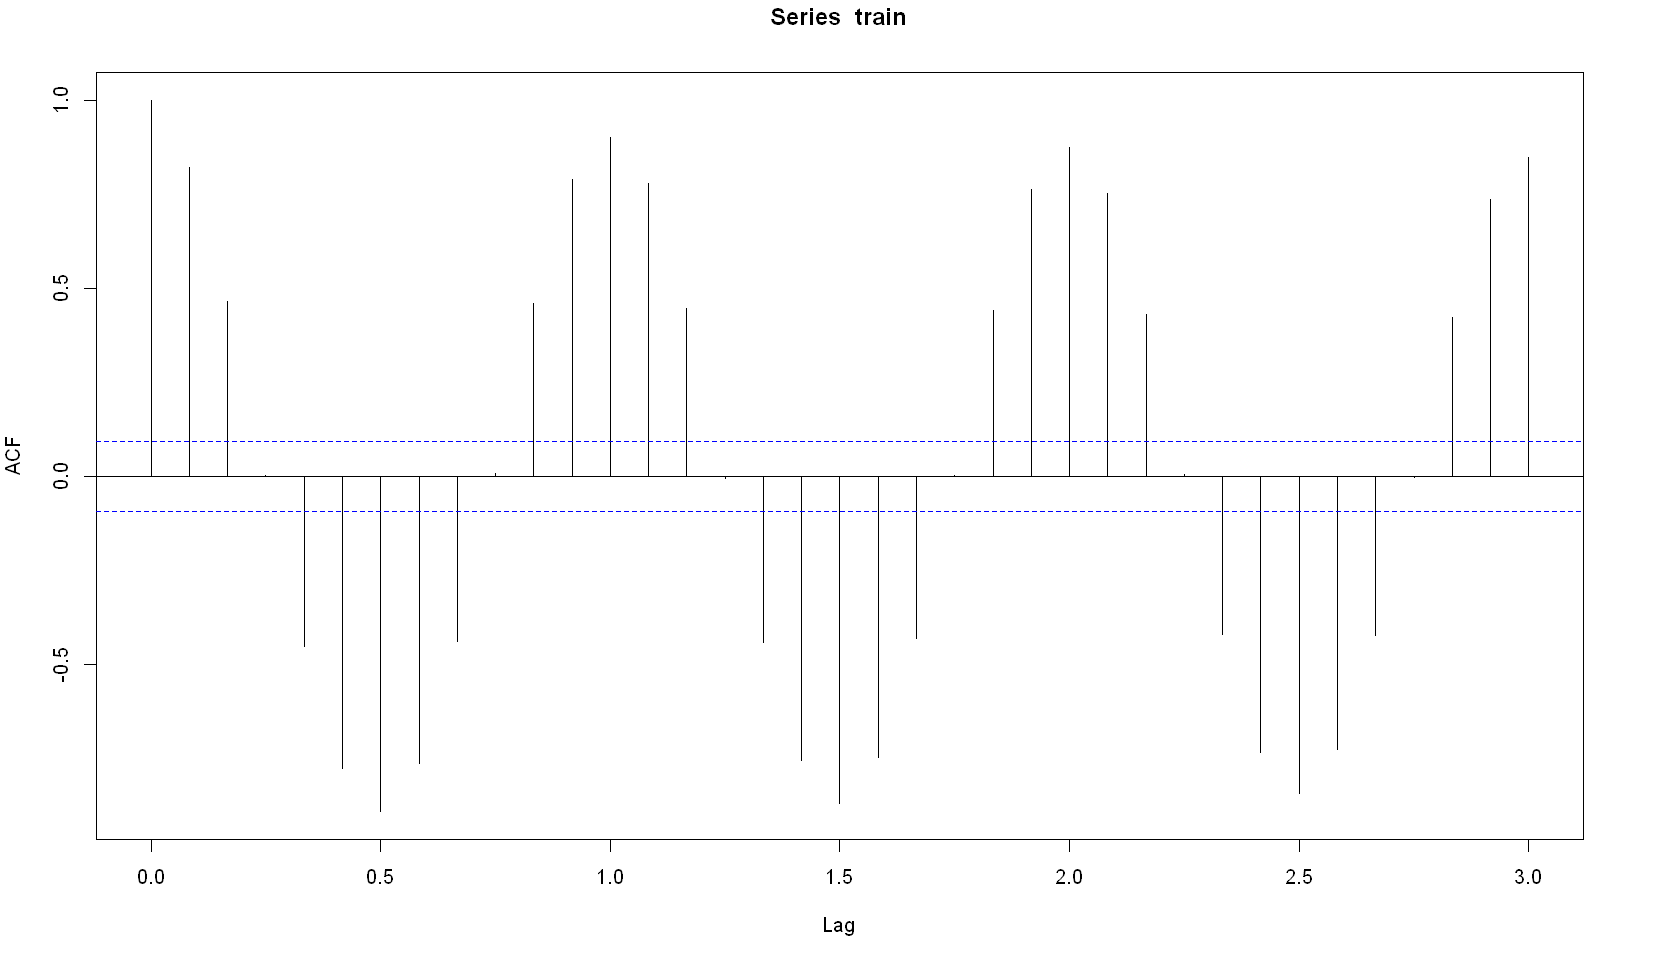

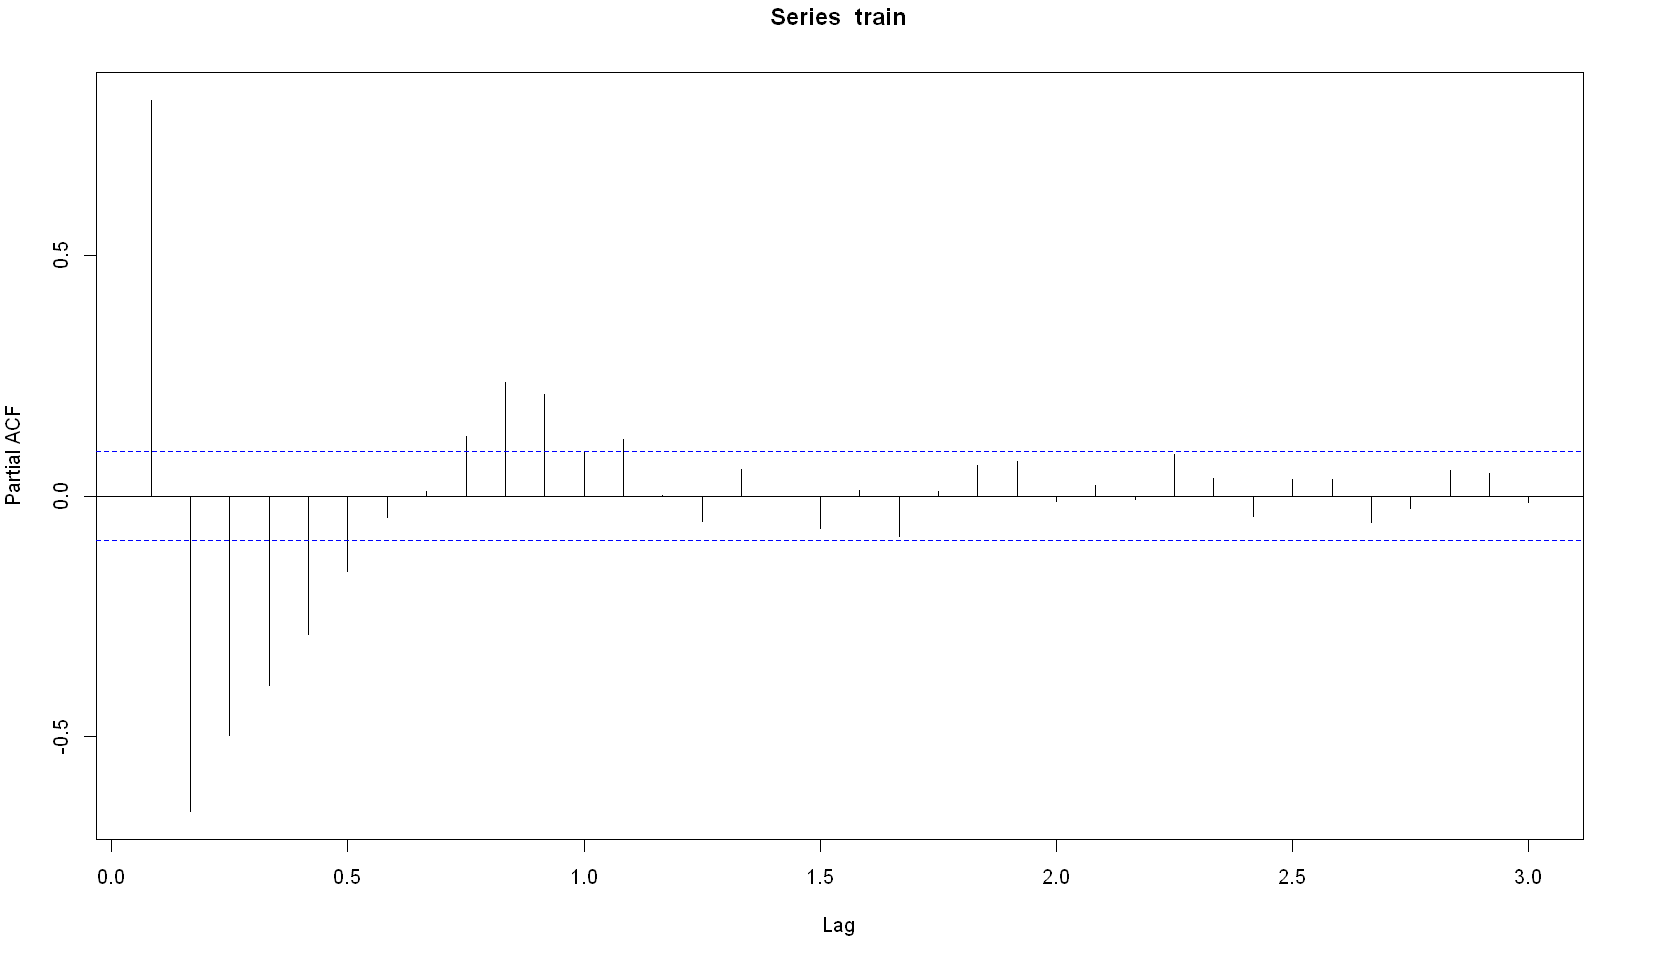

In [26]:
par(mar=c(5,4,3,4))
acf(train, lag.max = 36)
pacf(train, lag.max = 36)

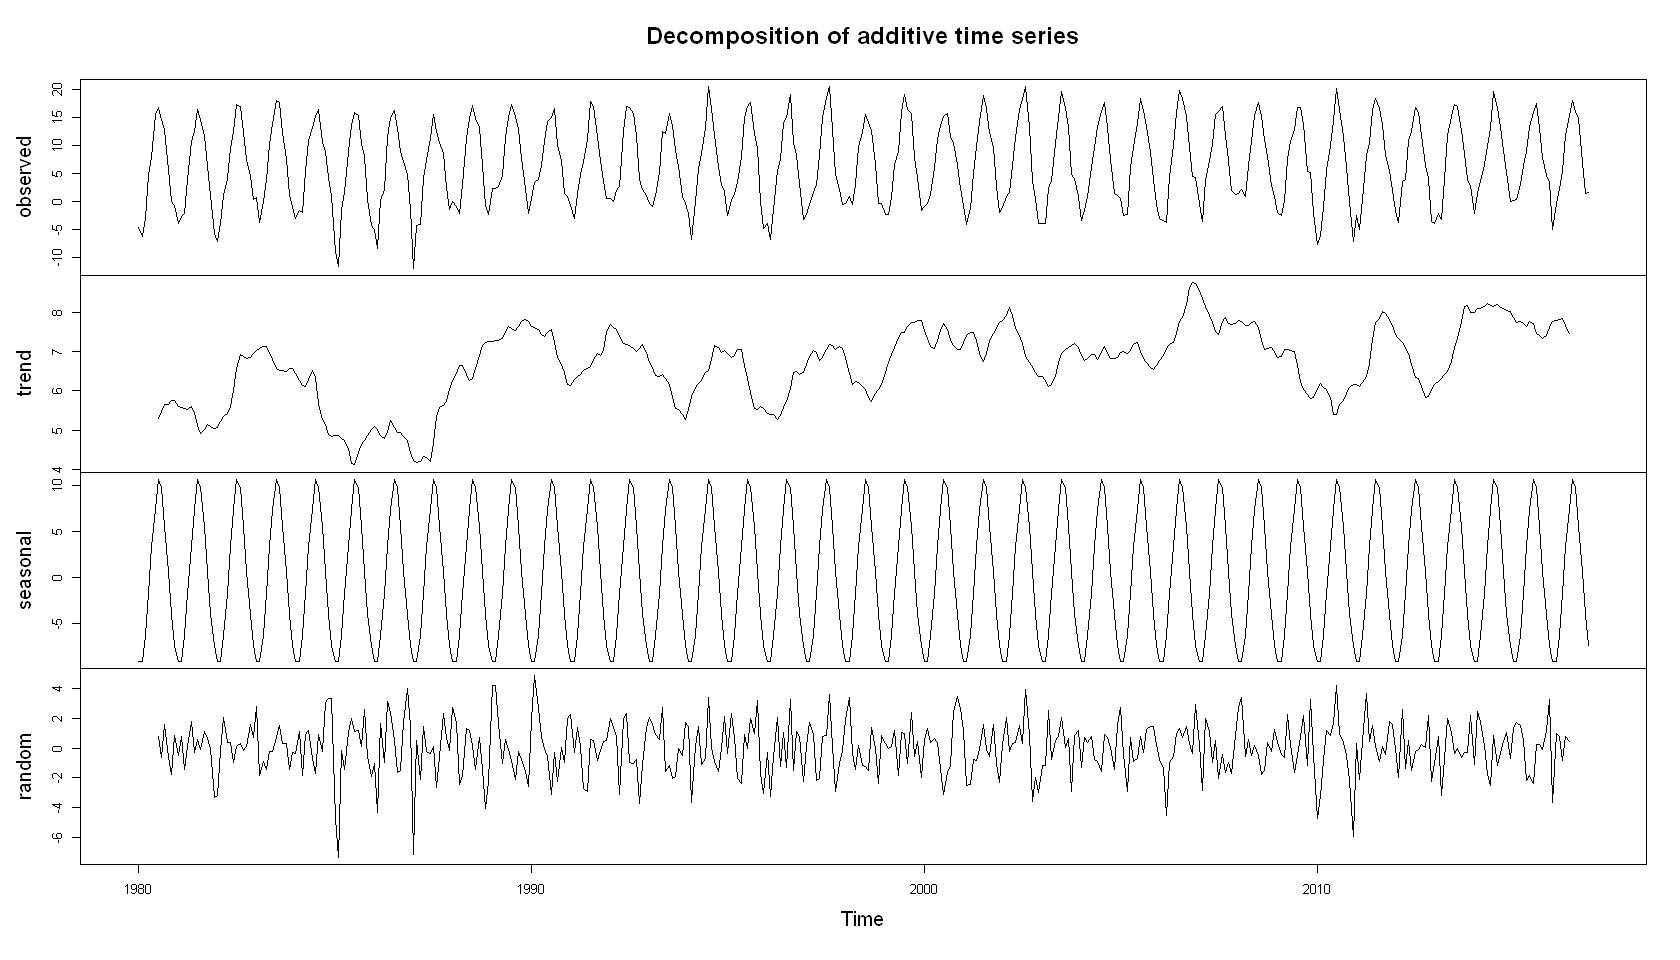

In [29]:
decomp = decompose(train)
plot(decomp)

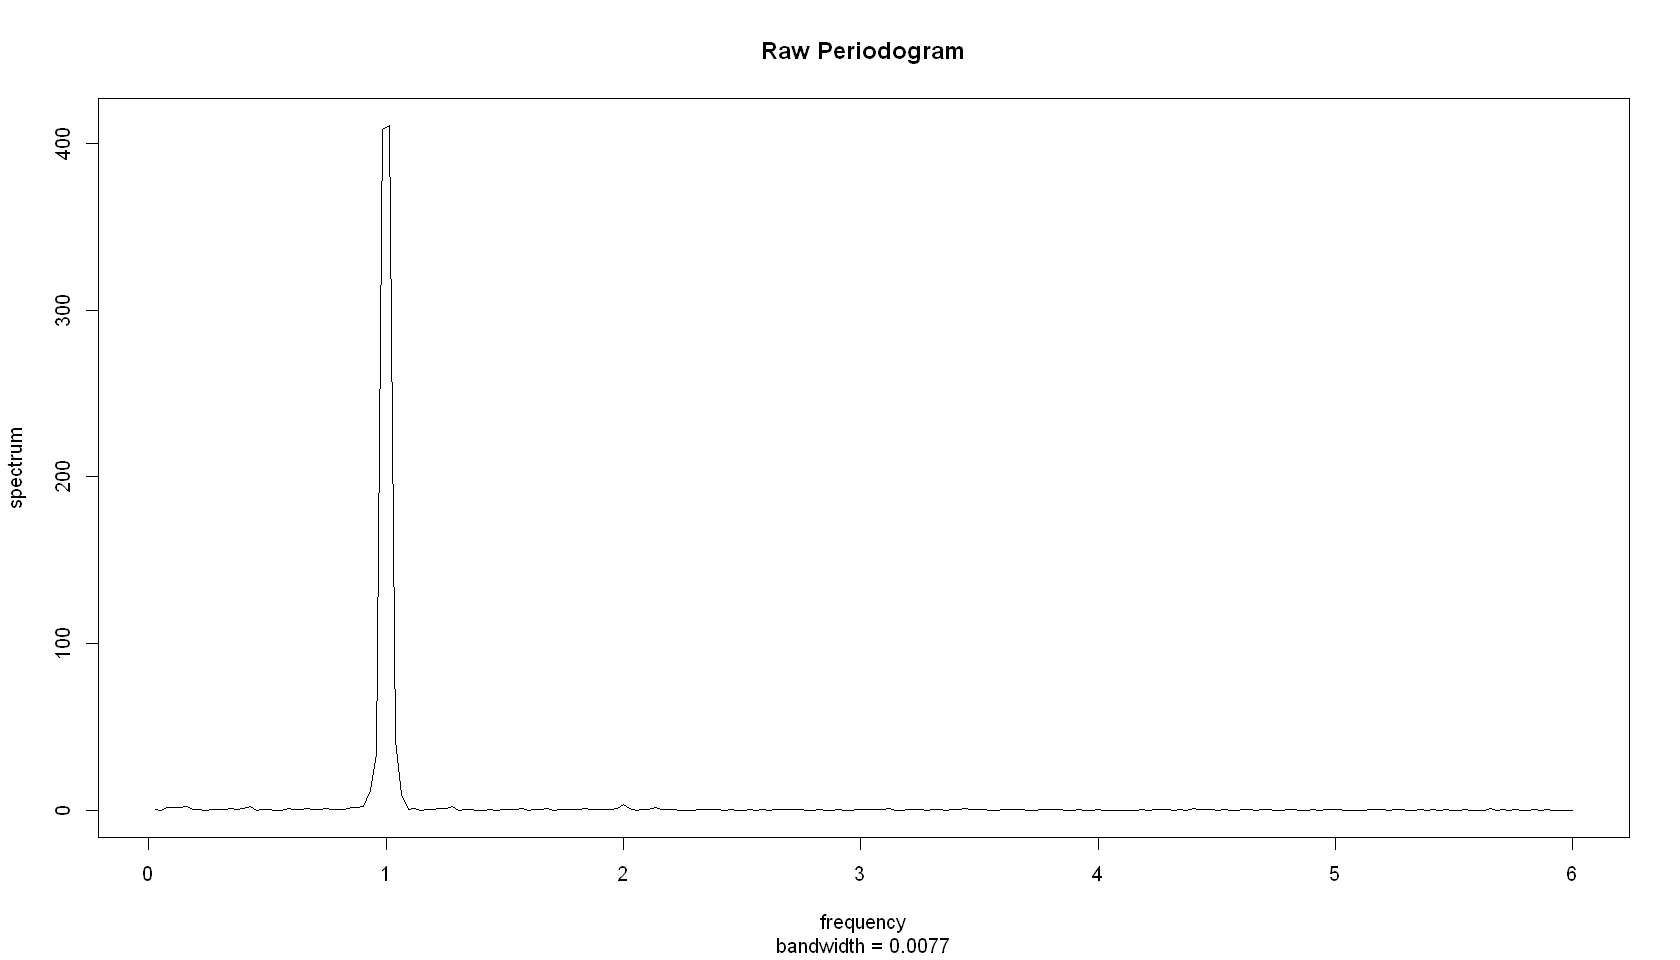

In [30]:
spec.pgram(train, log="no", main="Raw Periodogram")

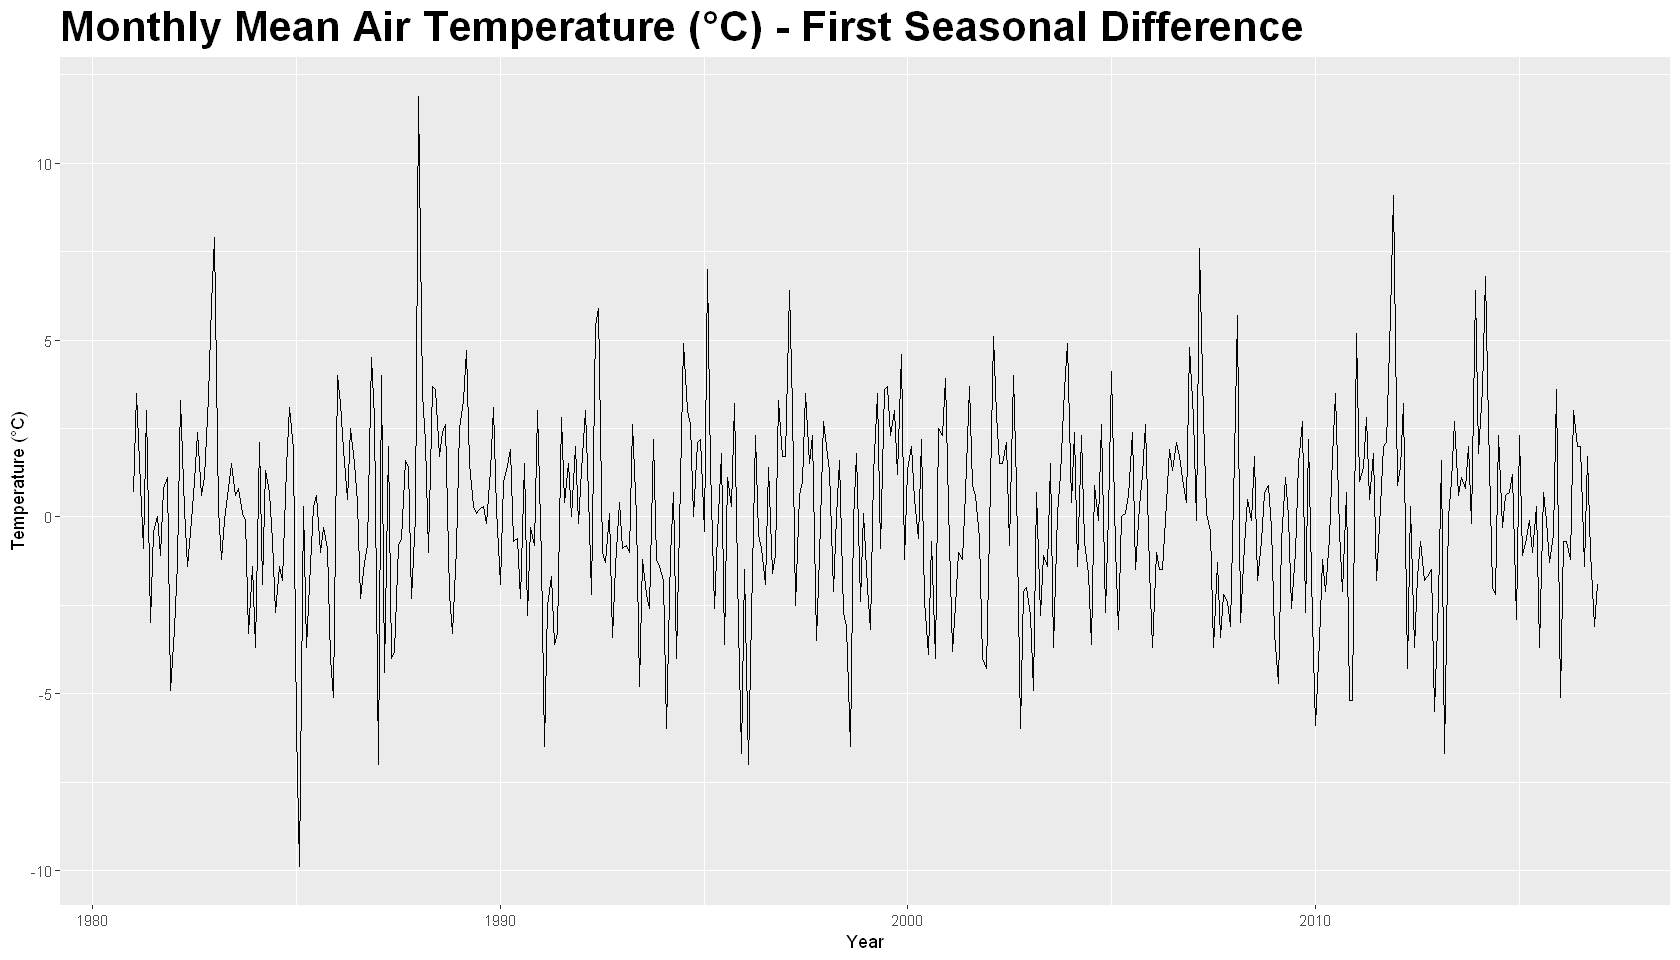

In [38]:
# Seasonal difference
train.diff = diff(train, lag=12)

autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    theme(plot.title = element_text(size = 25, face = "bold")) +
    guides(colour = guide_legend(title.hjust = 20))

In [41]:
adf.test(train.diff)

Warning message in adf.test(train.diff):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -6.5205, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [42]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.021325, Truncation lag parameter = 5, p-value = 0.1


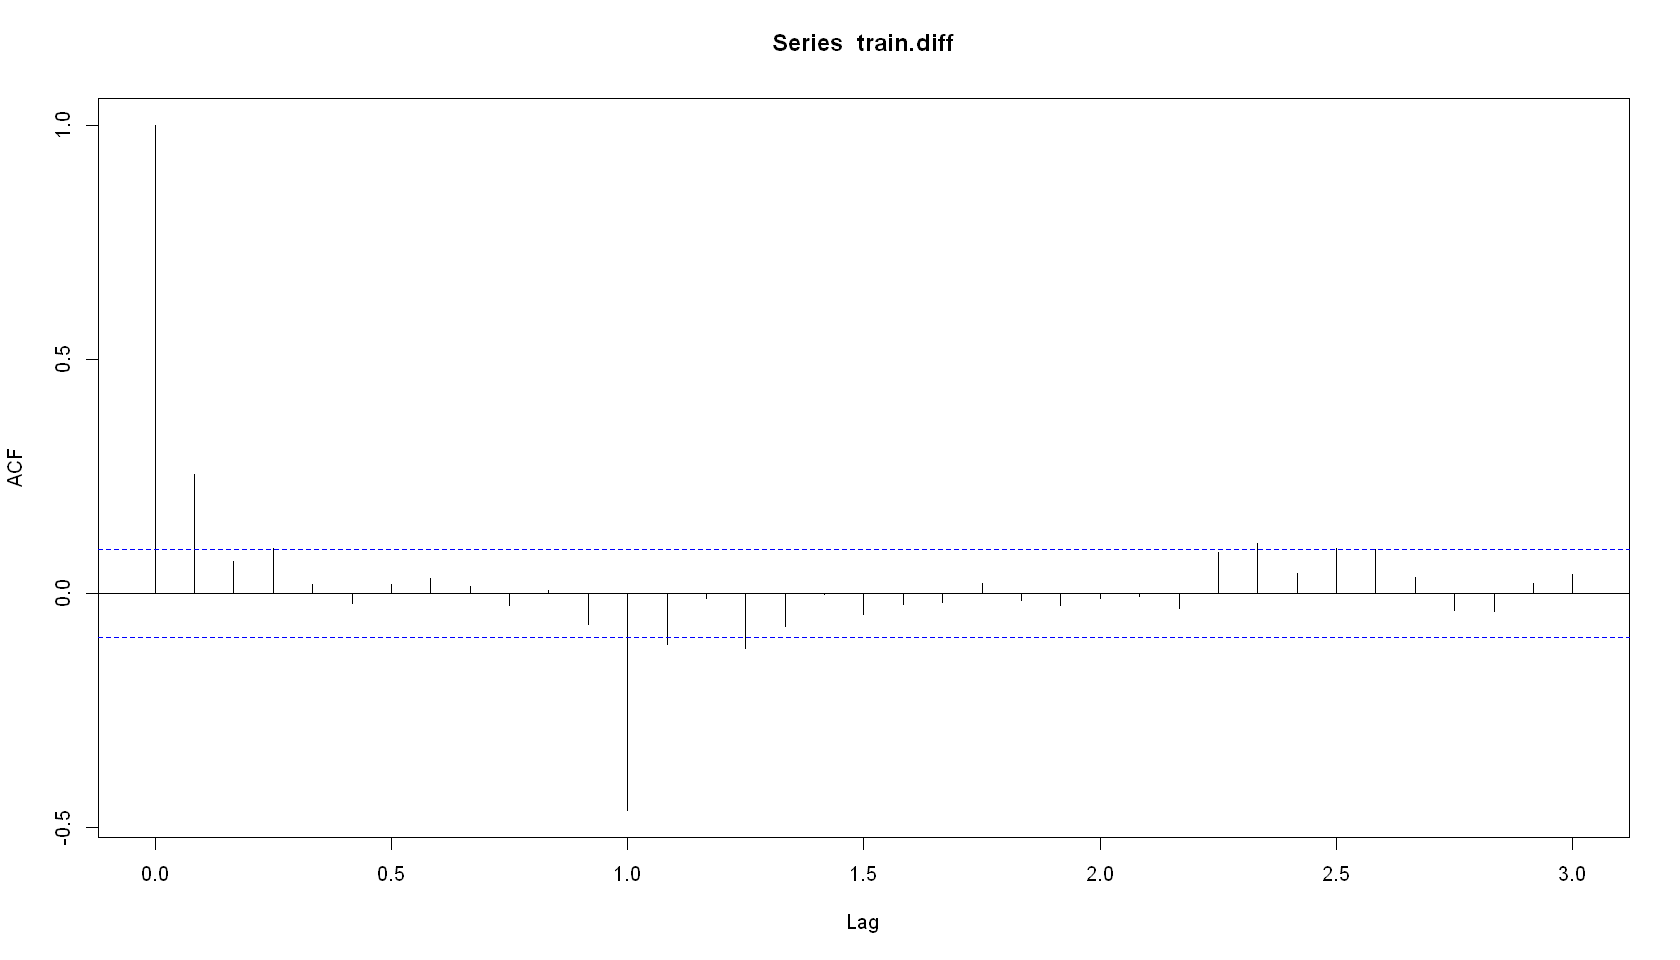

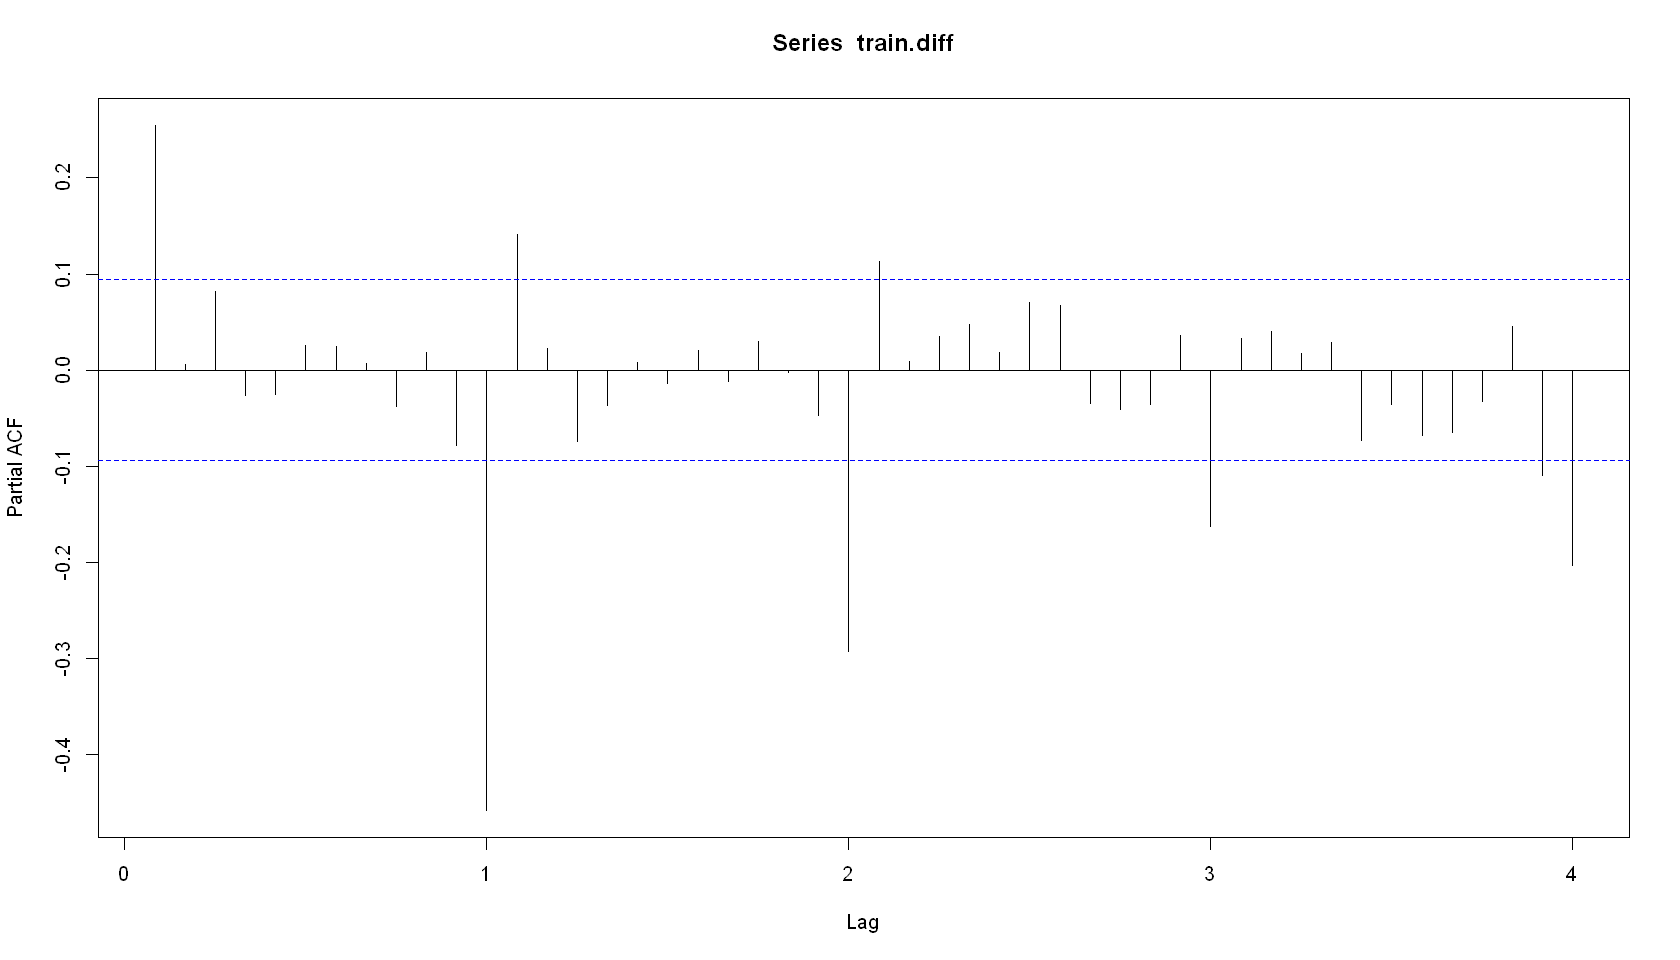

In [44]:
acf(train.diff, lag.max=36)
pacf(train.diff, lag.max=48)

In [36]:
p <- q <- P <- Q <- 0:3
grid <- expand.grid(p=p, q=q, P=P, Q=Q)
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=4)

arima_search <- lapply(1:nrow(grid), function(i){
    mdl <- NULL
    mdl <- try(arima(train, order=c(grid$p[i], 0, grid$q[i]), 
                     seasonal=list(order=c(grid$P[i], 1, grid$Q[i]), period=12)))
    
    aic_scores <- data.frame(p = grid$p[i], d=0, q=grid$q[i], P=grid$P[i], D=1, Q=grid$Q[i], AIC = mdl$aic)
}) %>% bind_rows() %>% arrange(AIC)

head(arima_search)

Warning message in arima(train, order = c(grid$p[i], 0, grid$q[i]), seasonal = list(order = c(grid$P[i], :
"possible convergence problem: optim gave code = 1"


,p,d,q,P,D,Q,AIC
,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,2,0,1,0,1,1,1828.821
2,1,0,2,0,1,1,1832.071
3,1,0,0,0,1,1,1834.952
4,1,0,0,1,1,2,1835.330
5,1,0,1,0,1,1,1836.200
6,2,0,0,0,1,1,1836.403


# Residual Check


	Ljung-Box test

data:  Residuals from ARIMA(2,0,0)(2,1,1)[12]
Q* = 16.738, df = 19, p-value = 0.6076

Model df: 5.   Total lags used: 24



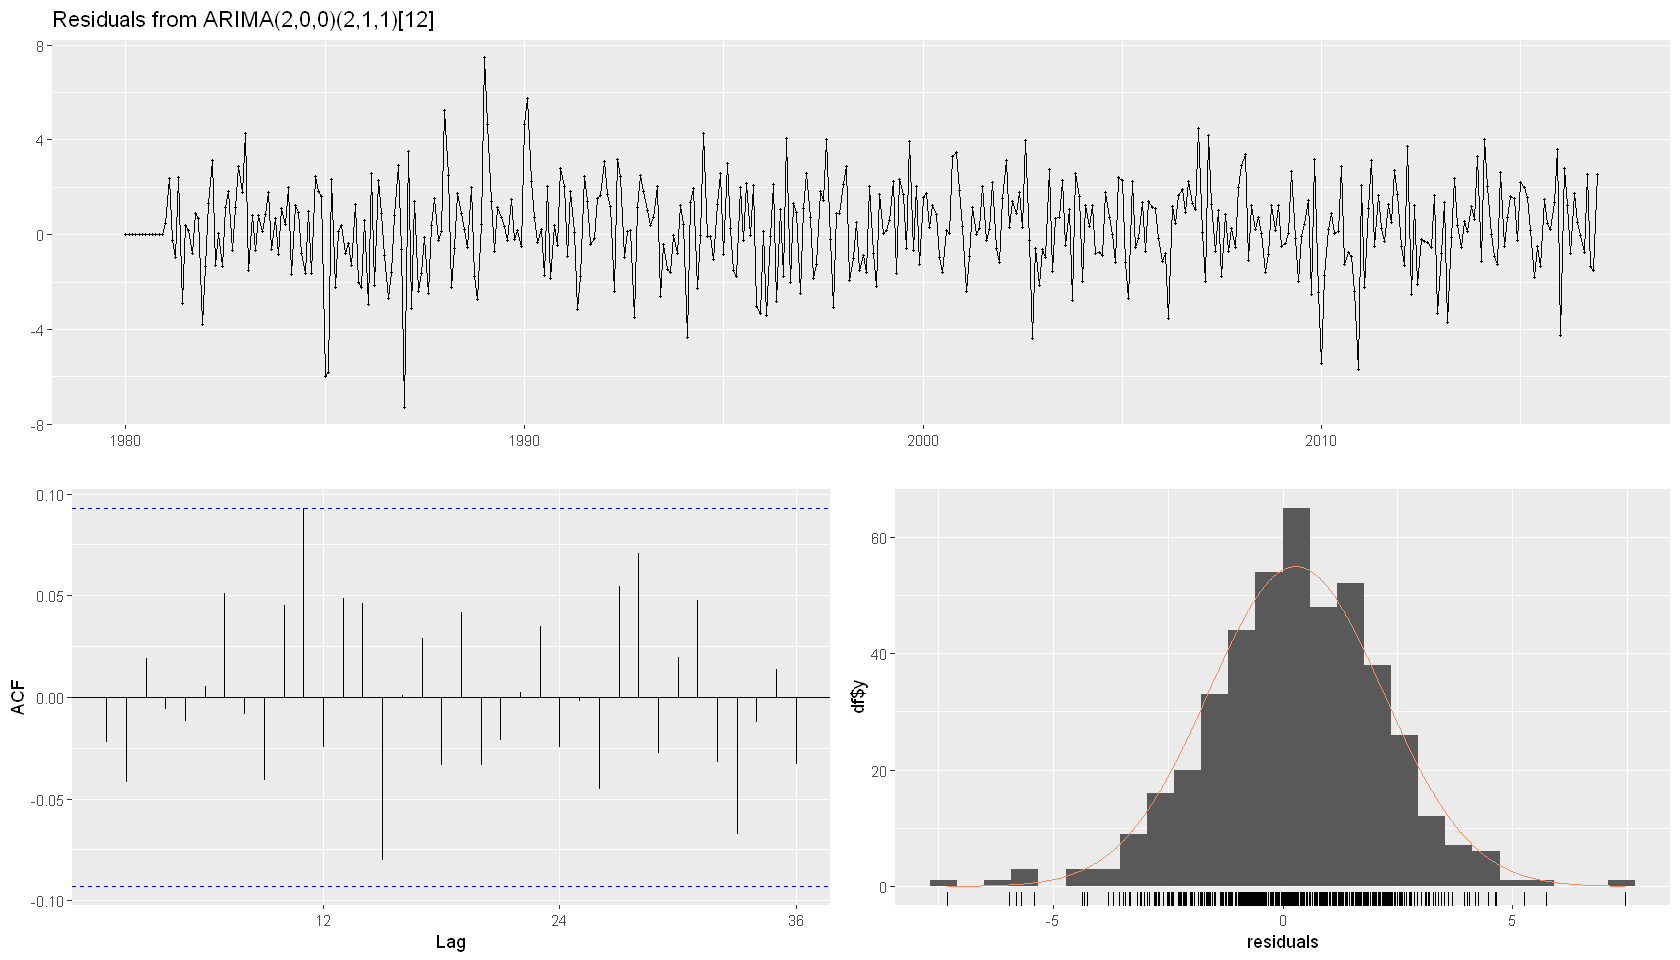

In [60]:
checkresiduals(mdl)

In [61]:
Box.test(mdl$residuals)


	Box-Pierce test

data:  mdl$residuals
X-squared = 0.217, df = 1, p-value = 0.6413



	Shapiro-Wilk normality test

data:  mdl$residuals
W = 0.99017, p-value = 0.004606


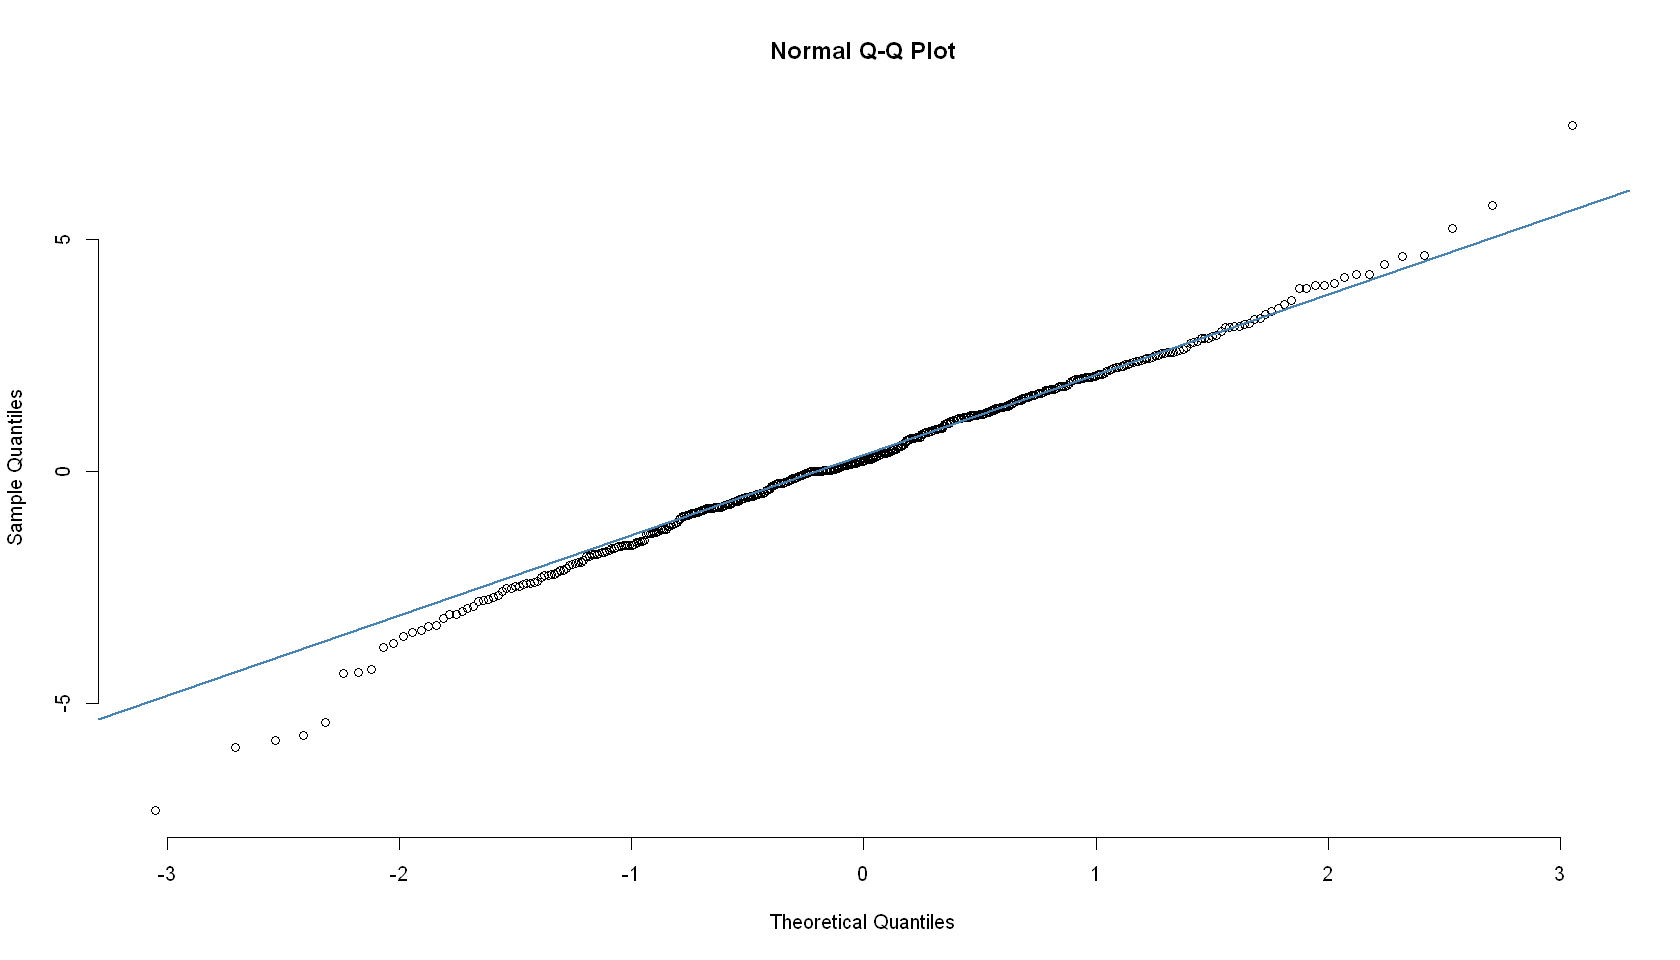

In [64]:
qqnorm(mdl$residuals, pch=1, frame=FALSE)
qqline(mdl$residuals, col="steelblue", lwd=2)
shapiro.test(mdl$residuals)

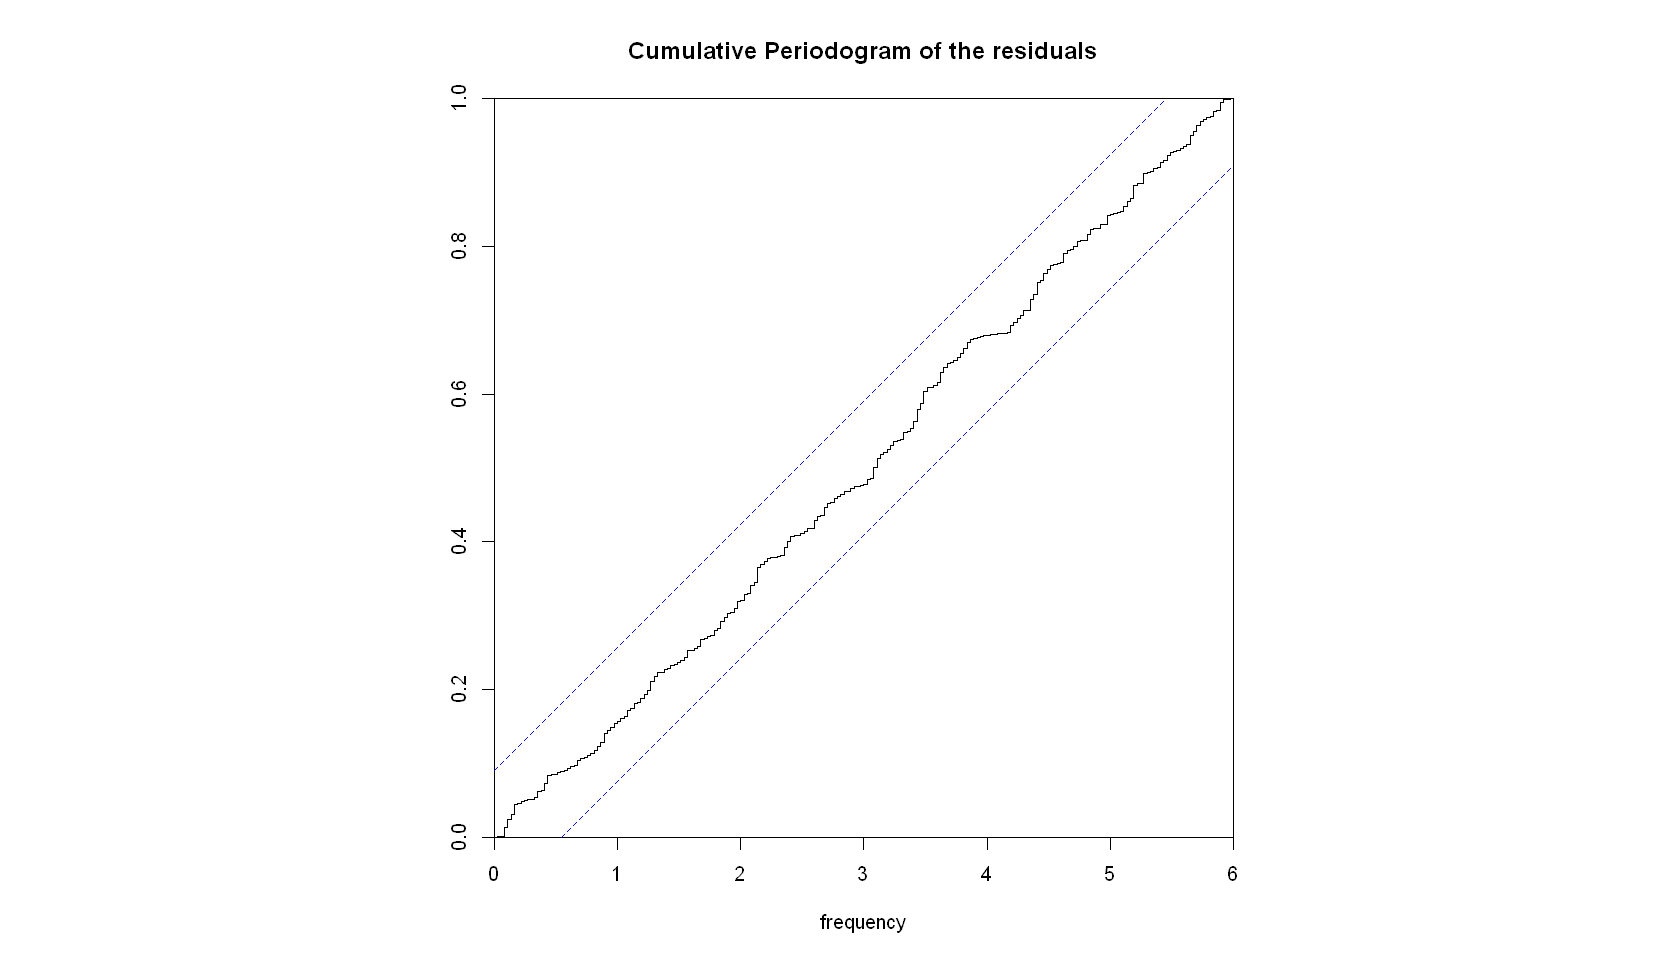

In [65]:
cpgram(mdl$residuals, main="Cumulative Periodogram of the residuals")

# Forecasting

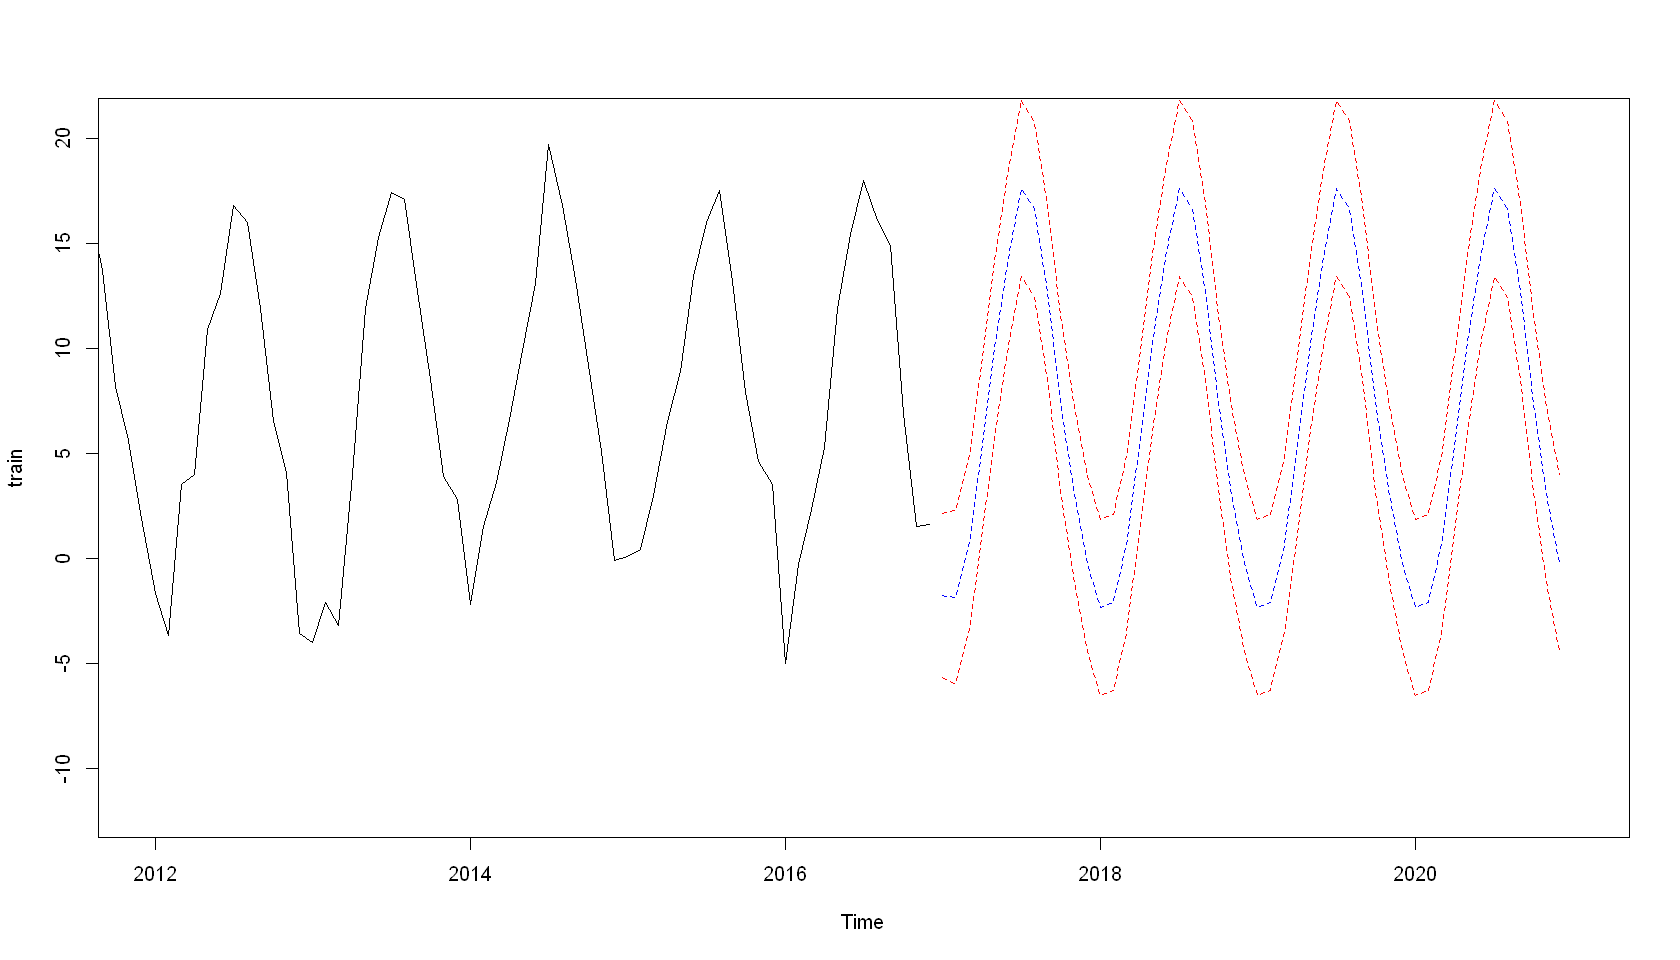

In [56]:
# Forecasting

mdl <- arima(train, order = c(2, 0, 0), seasonal=list(order=c(2,1,1)))
pred <- predict(mdl, n.ahead=48)
ts.plot(train, xlim= c(2012, 2021))

points(pred$pred, type="l", col="blue", lty=2)
lines(pred$pred+2*pred$se, col="red", lty=2)
lines(pred$pred-2*pred$se, col="red", lty=2)

In [66]:
mdl


Call:
arima(x = train, order = c(2, 0, 0), seasonal = list(order = c(2, 1, 1)))

Coefficients:
         ar1     ar2     sar1     sar2     sma1
      0.3437  0.0359  -0.0016  -0.0038  -0.9347
s.e.  0.0499  0.0518   0.0589   0.0554   0.0359

sigma^2 estimated as 3.806:  log likelihood = -914.2,  aic = 1840.4